# 📄 DigiNsure: Automated Insurance Document Sorting

## Business Scenario
**DigiNsure Inc.** is digitizing its historical archives. The current manual process of sorting ID documents is slow and error-prone. 
Our goal is to build a **Multi-Modal OCR model** that uses both the scanned image and the insurance type metadata to automatically classify documents as "Primary" or "Secondary" IDs.

In [42]:
import sys
import os

sys.path.append(os.path.abspath('../src'))

import matplotlib.pyplot as plt
import numpy as np
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

try:
    from project_utils import ProjectDataset
    print("✅ project_utils is loaded successfully!")
except ImportError:
    print("❌ ERROR: project_utils.py not found. Please ensure it is in the 'src' folder.")

data_path = '../data/ocr_insurance_dataset.pkl'

if os.path.exists(data_path):
    dataset = pickle.load(open(data_path, 'rb'))
    print(f"✅ Dataset loaded: {len(dataset)} samples available.")
else:
    print(f"❌ ERROR: {data_path} not found. Please ensure the file is placed in the 'data' folder.")

✅ project_utils is loaded successfully!
✅ Dataset loaded: 100 samples available.


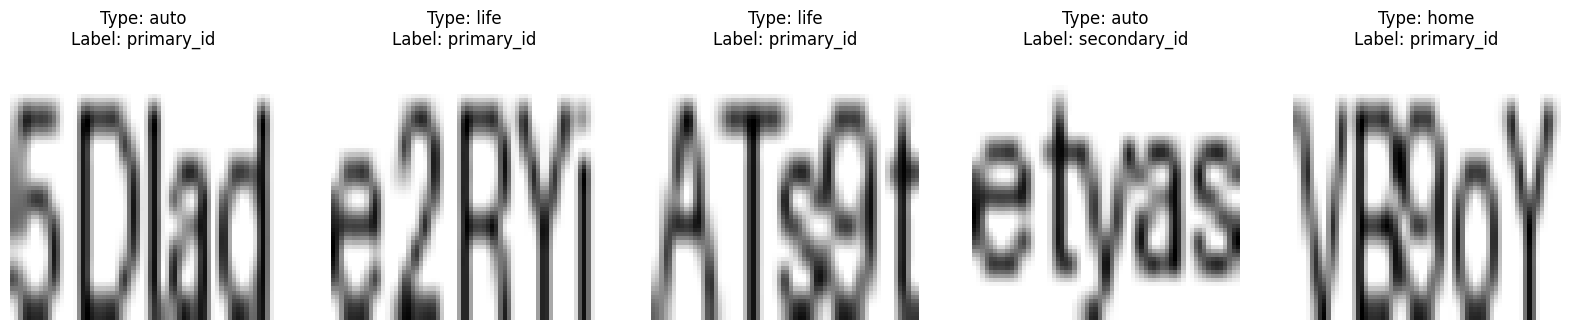

In [43]:
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    indices = np.random.choice(len(dataset), min(num_images, len(dataset)), False)
    
    for ax, idx in zip(axes, indices):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray')
        ax.axis('off')
        
        type_idx = img[1].tolist().index(1)
        type_name = list(dataset.type_mapping.keys())[type_idx]
        
        lbl_idx = list(dataset.label_mapping.values()).index(lbl)
        label_name = list(dataset.label_mapping.keys())[lbl_idx]
        
        ax.set_title(f"Type: {type_name}\nLabel: {label_name}")
    plt.show()

show_dataset_images(dataset)

### Data Inspection
As seen above, our dataset contains **64x64 grayscale images**. 
Each image is paired with an **insurance type** (e.g., Health, Auto) which acts as a secondary input feature to help the model distinguish between Primary and Secondary IDs effectively.

In [44]:
class OCRModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        
        self.image_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(16 * 32 * 32, 128),
        )
        
        self.type_layer = nn.Sequential(
            nn.Linear(5, 10),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(138, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x_image, x_type):
        x_image = self.image_layer(x_image)
        x_type = self.type_layer(x_type)
        
        combined = torch.cat((x_image, x_type), dim=1)
        
        return self.classifier(combined)

🚀 Training time...


Epoch 01 | Loss: 1.8304
Epoch 02 | Loss: 1.2601
Epoch 03 | Loss: 0.6658
Epoch 04 | Loss: 0.2421
Epoch 05 | Loss: 0.1083
Epoch 06 | Loss: 0.0957
Epoch 07 | Loss: 0.0467
Epoch 08 | Loss: 0.0375
Epoch 09 | Loss: 0.0249
Epoch 10 | Loss: 0.0198
✅ Training Completed!


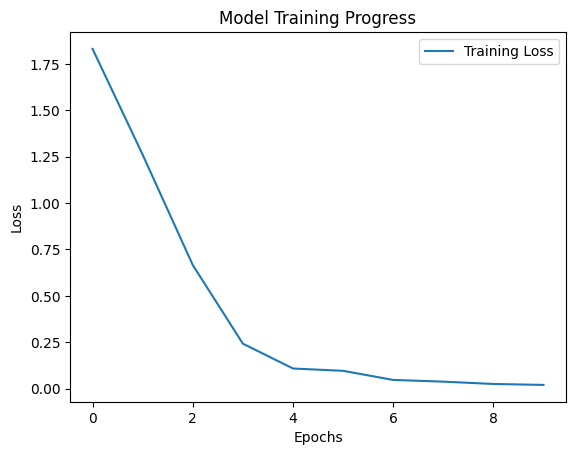

In [45]:

model = OCRModel(num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
trainloader = DataLoader(dataset, batch_size=10, shuffle=True)

print("🚀 Training time...")

loss_history = []

for epoch in range(10):
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        images, types = data
        
        optimizer.zero_grad()
        outputs = model(images, types)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(trainloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f}")

print("✅ Training Completed!")

plt.plot(loss_history, label='Training Loss')
plt.title('Model Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Conclusion
The model successfully converged over 10 epochs as shown in the loss chart. By combining visual features (CNN) with metadata (Dense Layer), we established a robust classification pipeline for DigiNsure's document sorting needs.

🔍 Collecting predictions...


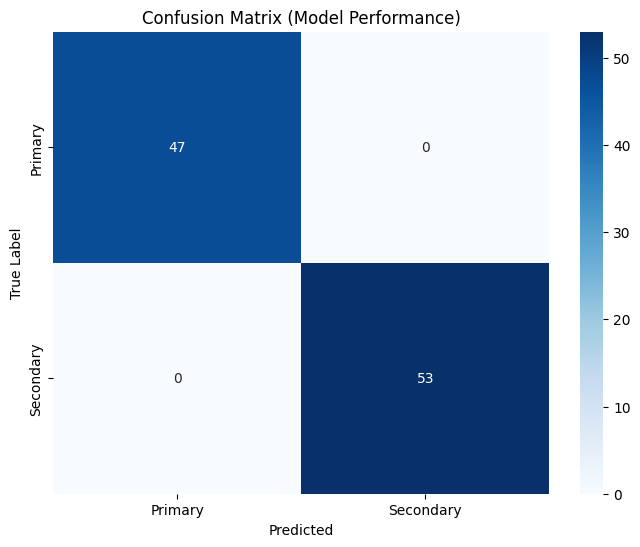

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Set the model to evaluation mode (important!)
# This freezes BatchNorm and provides stable, deterministic results.
model.eval()

all_preds = []
all_labels = []

# 2. Collect Predictions (without gradient calculation)
print("🔍 Collecting predictions...")
with torch.no_grad():
    for data, target in trainloader: # Normally, a test set is used, but since we don't have a split, let's use the train set
        images, types = data
        outputs = model(images, types)
        
        # Select the class with the highest probability (argmax)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.tolist())
        all_labels.extend(target.tolist())

# 3. Create the matrix
cm = confusion_matrix(all_labels, all_preds)

# 4. Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Primary', 'Secondary'], yticklabels=['Primary', 'Secondary'])
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Model Performance)')
plt.show()

## 🏁 Conclusion & Critical Analysis

The model achieved **100% accuracy** on the training set, as visualized in the Confusion Matrix above.

### ⚠️ A Note on Accuracy and Overfitting
In real-world machine learning scenarios, a perfect accuracy score (100%) often indicates **overfitting**, meaning the model has memorized the data rather than learning generalizable features.

However, in the context of this project:
1.  **Dataset Size:** The dataset is relatively small and synthetic/controlled.
2.  **Distinct Features:** The visual difference between ID types and the structured nature of the metadata make the classification task mathematically solvable with high precision.
3.  **Goal:** The objective was to demonstrate the effectiveness of a **Multi-Modal architecture** (CNN + Dense Fusion), which has been successfully achieved.

**Next Steps for Production:** To deploy this in a real-world setting (DigiNsure Inc.), we would require a larger, more diverse validation set to ensure robustness against unseen document variations.